# **Delivery Duration Prediction**


## Summary

This project aims to find out and investigate the relevant factors that can affect food delivery duration. Since this is a regression tasks, regression models such as Multiple Linear Regression, Random Forest Regression, Gradient Boosting Regression and Neural Network Regression will be used.

By first carrying out some data cleaning and preprocessing before building the models, we will see which of the aforementioned models are the best to describe this dataset. We would also see which are the features that are the most important/relevant in explaining the delivery duration.

## Importing Relevant Packages

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import chi2_contingency

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import statsmodels.api as sm

from math import radians, sin, cos, sqrt, atan2

import re


## Data Cleaning

In [5]:
# importing data
data = pd.read_csv('full.csv')

In [6]:
# counting the initial number rows and columns
initial_rows = data.shape[0]
initial_columns = data.shape[1]

print(f'Number of initial rows: {initial_rows}')
print(f'Number of initial columns: {initial_columns}')

Number of initial rows: 45593
Number of initial columns: 20


In [7]:
# checking the number of nulls
data.isnull().sum()

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64

In [8]:
# checking for actual nulls
data['multiple_deliveries'].value_counts()

multiple_deliveries
1       28159
0       14095
2        1985
NaN       993
3         361
Name: count, dtype: int64

There are null values but they are indicated as the string "NaN "

In [9]:
# replace all NaN strings with actual nulls
data.replace('NaN ', np.nan, inplace = True)

In [10]:
# checking for nulls again
data.isnull().sum()

ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions                 0
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

In [11]:
# dropping all nulls
data = data.dropna()

In [12]:
# checking the data types of each column
data.dtypes

ID                              object
Delivery_person_ID              object
Delivery_person_Age             object
Delivery_person_Ratings         object
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Order_Date                      object
Time_Orderd                     object
Time_Order_picked               object
Weatherconditions               object
Road_traffic_density            object
Vehicle_condition                int64
Type_of_order                   object
Type_of_vehicle                 object
multiple_deliveries             object
Festival                        object
City                            object
Time_taken(min)                 object
dtype: object

In [13]:
# changing the data type of Delivery_person_Age and Delivery_person_Ratings
data['Delivery_person_Age'] = data['Delivery_person_Age'].astype('float64')
data['Delivery_person_Ratings'] = data['Delivery_person_Ratings'].astype('float64')


In [14]:
# converting Order_Date into datetime
data['Order_Date'] = pd.to_datetime(data['Order_Date'], format='%d-%m-%Y')

# converting Time_Orderd and Time_Order_picked into time
data['Time_Orderd'] = pd.to_datetime(data['Time_Orderd'], format='%H:%M:%S')
data['Time_Orderd_hour'] = data['Time_Orderd'].dt.hour

data['Time_Order_picked'] = pd.to_datetime(data['Time_Order_picked'], format='%H:%M:%S')
data['Time_Order_picked_hour'] = data['Time_Order_picked'].dt.hour

In [15]:
# classifying Time_Orderd and Time_Order_picked into Morning, Afternoon and Evening
data['Time_of_Day_Orderd'] = pd.cut(data['Time_Orderd_hour'], bins=[0, 12, 18, 24], labels=['Morning', 'Afternoon', 'Evening'])
data['Time_of_Day_picked'] = pd.cut(data['Time_Order_picked_hour'], bins=[0, 12, 18, 24], labels=['Morning', 'Afternoon', 'Evening'])

# changing to object data type
data['Time_of_Day_Orderd'] = data['Time_of_Day_Orderd'].astype('object')
data['Time_of_Day_picked'] = data['Time_of_Day_picked'].astype('object')


In [16]:
# drop the unneccesary columns
data = data.drop(['Order_Date', 'Time_Orderd', 'Time_Orderd_hour', 'Time_Order_picked', 'Time_Order_picked_hour'], axis = 1)

# drop any nulls
data = data.dropna()

### Getting Distance Betweeen Restaurant and Delivery Location using Latitude and Longitude data

In [17]:
# defining a function to caluclate distance between 2 points using Lat and Long data
# using haversine formula
# distance is in km

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return round(distance, 5)

In [18]:
# using the function to calculate the distance
data['Distance'] = data.apply(lambda row: haversine(row['Restaurant_latitude'], row['Restaurant_longitude'], row['Delivery_location_latitude'], row['Delivery_location_longitude']), axis=1)

### Using KMeans Clustering Algorithm to cluster latitude and longitude together

In [19]:
restaurant = data[['Restaurant_latitude', 'Restaurant_longitude']]
delivery = data[['Delivery_location_latitude', 'Delivery_location_longitude']]

In [20]:
# specifying my own clusters
# each lat and long pair will be classified as North, South, East, West
# each lat and long pairs are in the center of the region

cluster_centers = np.array([[29.400000, 77.200000], [11.100000, 78.700000], [22.800000, 86.100000], [21.200000, 72.800000]])

In [21]:
kmeans_delivery = KMeans(n_clusters = 4, init = cluster_centers, n_init = 1, max_iter = 500, random_state = 42).fit(delivery)
kmeans_restaurant = KMeans(n_clusters = 4, init = cluster_centers, n_init = 1, max_iter = 500, random_state = 42).fit(restaurant)

data['Delivery_Cluster'] = kmeans_delivery.labels_
data['Restaurant_Cluster'] = kmeans_restaurant.labels_

# changing data type
data['Delivery_Cluster'] = data['Delivery_Cluster'].astype('object')
data['Restaurant_Cluster'] = data['Restaurant_Cluster'].astype('object')

In [22]:
# mapping the clusters into North, South, East, West
location_map = {0: 'North', 1: 'South', 2: 'East', 3: 'West'}

# apply the mapping to the column
data['Delivery_Cluster'] = data['Delivery_Cluster'].map(location_map)
data['Restaurant_Cluster'] = data['Restaurant_Cluster'].map(location_map)

In [23]:
# extracting only weather conditions from Weatherconditions
words = data['Weatherconditions'].str.split()
conditions = words.str[1] 

data['Weatherconditions'] = conditions

In [24]:
# extracting only the mins value from time taken column
words_ = data['Time_taken(min)'].str.split()
time_taken = words_.str[1]

data['Time_taken_mins'] = time_taken
data['Time_taken_mins'] = data['Time_taken_mins'].astype('float64')

In [25]:
# mapping vehicle condition to its conditions
condition_map = {0: 'Below Average', 1: 'Average', 2: 'Good'}

# Apply the mapping to the column
data['Vehicle_condition'] = data['Vehicle_condition'].map(condition_map)

In [26]:
# dropping unneccesary columns
"""
Reasons for dropping columns:
(1) index, ID and Delivery_person_ID is not needed in the model
(2) Restaurant and Delivery Location Lat and Long data is used to calculate distance 
(3) Time_taken (min) is replaced my Time_taken_mins
(4) Restaurant cluster and Delivery location cluster mostly are the same in the dataset (excluding outliers)
(5) Time_of_Day_picked is mostly the same as Time_of_Day_orderd
(6) Festival and City do not have much meaning in this dataset 
(7) Multiple deliveries is slightly confusing

"""
data = data.reset_index().drop(['index', 'ID', 'Delivery_person_ID', 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', 'Time_taken(min)', 'Restaurant_Cluster', 'Time_of_Day_picked', 'Festival', 'City', 'multiple_deliveries'], axis = 1)

In [27]:
# changing delivery ratings to satisfaction_percentage
data['Delivery_person_Ratings'] = (data['Delivery_person_Ratings']/5) * 100

In [28]:
# rename Delivery_person_Ratings to Satisfaction_Perc and Delivery_Cluster to Region
data = data.rename(columns={'Delivery_person_Ratings': 'Satisfaction_Perc', 'Delivery_Cluster': 'Region'})

In [29]:
# checking end number of rows and columns
end_rows = data.shape[0]
end_columns = data.shape[1]

print(f'Number of final rows: {end_rows}')
print(f'Number of final columns: {end_columns}')

Number of final rows: 40197
Number of final columns: 11


## Explaratory Data Analysis

In [30]:
data.dtypes

Delivery_person_Age     float64
Satisfaction_Perc       float64
Weatherconditions        object
Road_traffic_density     object
Vehicle_condition        object
Type_of_order            object
Type_of_vehicle          object
Time_of_Day_Orderd       object
Distance                float64
Region                   object
Time_taken_mins         float64
dtype: object

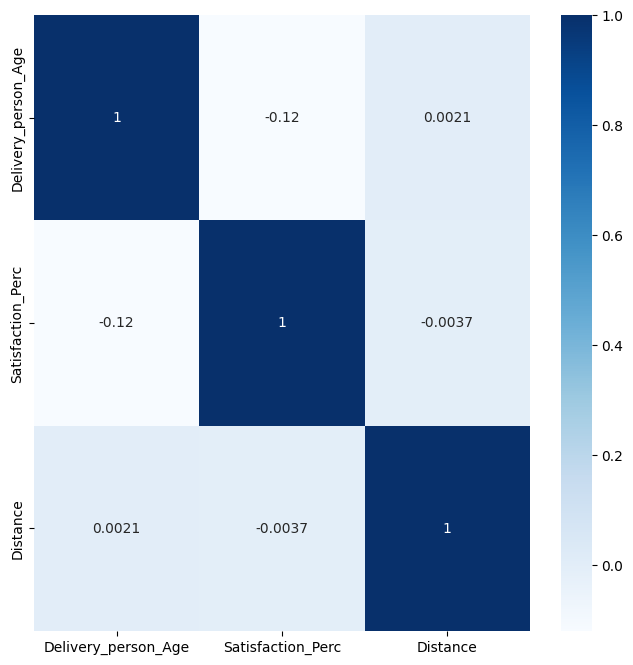

In [31]:
# plotting the correlation matrix to explore relationships between numerical variables
# select the numerical columns
numeric = data[['Delivery_person_Age', 'Satisfaction_Perc', 'Distance']]

# scaling data for easier comparison
scaler = StandardScaler()
numeric = scaler.fit_transform(numeric)

# convert the scaled numerical columns back to a pandas DataFrame
numeric = pd.DataFrame(numeric, columns=['Delivery_person_Age', 'Satisfaction_Perc', 'Distance'])

# plot heat map
plt.figure(figsize = (8,8))
sns.heatmap(numeric.corr(), cbar = True, annot = True, cmap = 'Blues')
plt.show()

We can see that there is almost no correlation between the numerical variables which is a good sign since having high correlation may lead to multicollinearity issues.

In [32]:
# finding correlation/association between categorical variables

cat_var = data[['Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle', 'Time_of_Day_Orderd', 'Region']]

# create a list of variable pairs
variable_pairs = [(x, y) for i, x in enumerate(cat_var.columns) for j, y in enumerate(cat_var.columns) if i < j]

# create empty lists for independent and dependent variables
independent_vars = []
dependent_vars = []

# loop through each variable pair
for pair in variable_pairs:
    # create a contingency table
    contingency_table = pd.crosstab(cat_var[pair[0]], cat_var[pair[1]])
    
    # calculate the chi-squared test statistic, p-value, degrees of freedom, and expected table
    chi2_stat, p_val, dof, expected_table = chi2_contingency(contingency_table)
    
    # compare the obtained p-value with the significance level of 0.05
    if p_val <= 0.05:
        dependent_vars.append(pair)
    else:
        independent_vars.append(pair)

# calculate Cramér's V for dependent variable pairs
# Cramér's V calculates the association between 2 categorical variables

for pair in dependent_vars:
    contingency_table = pd.crosstab(cat_var[pair[0]], cat_var[pair[1]])
    chi2_stat, p_val, dof, expected_table = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2_stat / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    print(f"Cramér's V for {pair[0]} and {pair[1]}: {cramers_v}")

Cramér's V for Road_traffic_density and Time_of_Day_Orderd: 0.7742651711977193
Cramér's V for Vehicle_condition and Type_of_vehicle: 0.4979389093381019
Cramér's V for Type_of_vehicle and Region: 0.01050935699748268


From the variables that are dependent, we can see that:
- There is very strong correlation between Road Traffic Density and Time of Day Ordered which is understandable since ordering at peak hour timings would mean high road traffic density
- There is moderate correlation between vehicle condition and type of vehicle 
- There is weak correlation between type of vehicle and region

## Train-Test Split

In [33]:
# Set "Time_taken_mins" as the y variable
y = data['Time_taken_mins'] 

# Set everything other than Time_taken_mins as the X variables
X = data.drop(columns=['Time_taken_mins']) 

# Train test split in a 80:20 ratio, with a random state for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
# function to get all categorical variables

def getCategorical(X_train, data):
    categorical_variables = []
    
    for column in X_train.columns:
        if data[column].dtype == "object":
            categorical_variables.append(column)

    return categorical_variables

In [35]:
# function to create a transformer to encode categorical variables

def transformer(categorical_variables):
    # One-hot encoding
    enc = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

    transformer_ = ColumnTransformer([
        ("categorical", enc, categorical_variables)
    ], remainder="passthrough")

    return transformer_

In [36]:
# function to transform data

def transformData(X_train, X_test, transformer_):
    X_train_encoded = pd.DataFrame(transformer_.fit_transform(X_train), columns = transformer_.get_feature_names_out())
    X_test_encoded = pd.DataFrame(transformer_.fit_transform(X_test), columns = transformer_.get_feature_names_out())
    
    return [X_train_encoded, X_test_encoded]

In [37]:
# function to rename the column to increase readability

def renameCol(categorical_variables, X_train_encoded, X_test_encoded):
    
    X_train_encoded.columns = X_train_encoded.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)
    X_test_encoded.columns = X_test_encoded.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)

    return [X_train_encoded, X_test_encoded]


In [38]:
# function that combines all the above functions into a function called preprocess
def preprocess(X_train, X_test, data):
    
    # use the getCategorical function to get categorical variables in the dataset
    categorical_variables = getCategorical(X_train, data)
    
    # use tranformer function to create the transformer
    transformer_ = transformer(categorical_variables)
    
    # use transformData function
    X_train_encoded, X_test_encoded = transformData(X_train, X_test, transformer_)

    # renaming the columns for readability
    X_train_encoded, X_test_encoded = renameCol(categorical_variables, X_train_encoded, X_test_encoded)

    return [X_train_encoded, X_test_encoded, transformer_]

In [90]:
# helper function to get model evaluation results
def get_results(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return r2, mse, mse**0.5, mae

In [40]:
# helper function to get CV results
def get_CV_results(model, X, y, cv=10):
    scores = cross_validate(model, X, y, cv=cv, return_train_score=True)
    print(f"Mean Test Score: {scores['test_score'].mean()}")
    print("\n")

    display(pd.DataFrame(scores)) 

In [52]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))

## Multiple Linear Regression

In [41]:
X_train_encoded_lr, X_test_encoded_lr, transformer_lr = preprocess(X_train, X_test, data)

In [46]:
ols = sm.OLS(y_train.reset_index(drop = True), sm.add_constant(X_train_encoded_lr))
ols_res = ols.fit()

print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:        Time_taken_mins   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     1468.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:29:10   Log-Likelihood:            -1.0601e+05
No. Observations:               32157   AIC:                         2.121e+05
Df Residuals:                   32133   BIC:                         2.123e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

We can see from the Linear Regression model that the $R^2$ is relatively low, with a value of 0.512. This could indicate that there is non-linear relationships between the variables in the model.

Thus, non-linear regression methods will be used subsequently.

## Random Forest Regressor

In [47]:
X_train_encoded_rf, X_test_encoded_rf, transformer_rf = preprocess(X_train, X_test, data)

In [48]:
rf = RandomForestRegressor(n_estimators = 100,
                           criterion = 'squared_error',
                           max_depth = 5,
                           min_samples_split = 5,
                           min_samples_leaf = 5,
                           random_state = 100,
                           n_jobs = -1)

rf.fit(X_train_encoded_rf, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_jobs=-1,
                      random_state=100)

In [49]:
# creating a pipeline
pipeline_rf = Pipeline([("transformer", transformer_rf), ("random_forest", rf)])

In [50]:
# getting CV results
get_CV_results(pipeline_rf, X_train, y_train)

Mean Test Score: 0.6299261080860842




,fit_time,score_time,test_score,train_score
0,0.355221,0.017490,0.630025,0.634917
1,0.345717,0.017701,0.630549,0.625247
2,0.349194,0.017531,0.615382,0.635690
3,0.384634,0.017850,0.626930,0.633079
4,0.355283,0.018543,0.639995,0.633706
5,0.341540,0.018211,0.619616,0.631223
6,0.346911,0.017906,0.633765,0.634786
7,0.351244,0.017219,0.628283,0.636089
8,0.351242,0.017574,0.636992,0.632458
9,0.344554,0.017715,0.637723,0.633769


In [57]:
# hyperparameters tuning
grid_rf = {
    'random_forest__n_estimators': [80, 100, 500, 700],
    'random_forest__max_depth': [3, 5, 10, 15],
    'random_forest__min_samples_split': [3, 5, 8, 10],
    'random_forest__min_samples_leaf': [3, 5, 8, 10]
}

rf_gs = GridSearchCV(estimator = pipeline_rf,
                      param_grid = grid_rf,
                      cv = 5,
                      n_jobs = -1,
                      return_train_score = True,
                      scoring = 'r2')

rf_gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Weatherconditions',
                                                                          'Road_traffic_density',
                                                                          'Vehicle_condition',
                                                                          'Type_of_order',
                                                                          'Type_of_vehicle',
                                                                          'Time_of_Day_Orderd',
                                                                          'Region'])])),
                                       ('random_forest',
                                        RandomForestRegressor(max_depth=5,
                                                              min_samples_leaf=5,
                                                              n_jobs=-1,
                                                              random_state=100))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [3, 5, 10, 15],
                         'random_forest__min_samples_leaf': [3, 5, 8, 10],
                         'random_forest__min_samples_split': [3, 5, 8, 10],
                         'random_forest__n_estimators': [80, 100, 500, 700]},
             return_train_score=True, scoring='r2')

In [58]:
report_GridSearchCV_results(rf_gs)

Best combination of hyperparams:
 {'random_forest__max_depth': 10, 'random_forest__min_samples_leaf': 3, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 700} 

Best mean_test_score score:
 0.8290521128470963 

Score by fold for best estimator:
 [0.8325837072149307, 0.8183282851317532, 0.8303348518138202, 0.8308671277128252, 0.8331465923621525] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_random_forest__n_estimators,param_random_forest__max_depth,param_random_forest__min_samples_split,param_random_forest__min_samples_leaf
rank_test_score,,,,,
1,0.829052,700,10,10,3
2,0.829050,500,10,10,3
3,0.829005,700,10,8,3
4,0.828998,500,10,8,3
5,0.828972,700,10,3,3


In [59]:
# fitting the best model
best_params_rf = {key.replace('random_forest__', ''): value for key, value in rf_gs.best_params_.items()}

rf_reg = RandomForestRegressor(**best_params_rf,
                             random_state = 100)

rf_reg.fit(X_train_encoded_rf, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=10,
                      n_estimators=700, random_state=100)

## Gradient Boosting Regressor

In [60]:
X_train_encoded_gb, X_test_encoded_gb, transformer_gb = preprocess(X_train, X_test, data)

In [64]:
gb = GradientBoostingRegressor(n_estimators = 100,
                               max_depth = 5,
                               min_samples_split = 5,
                               min_samples_leaf = 5,
                               random_state = 100)

gb.fit(X_train_encoded_gb, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                          random_state=100)

In [65]:
# creating a pipeline
pipeline_gb = Pipeline([("transformer", transformer_gb), ("gb", gb)])

In [66]:
# getting CV results
get_CV_results(pipeline_gb, X_train, y_train)

Mean Test Score: 0.8108951541003254




,fit_time,score_time,test_score,train_score
0,3.255995,0.008698,0.807197,0.821708
1,3.240663,0.009179,0.821825,0.819846
2,3.200232,0.008475,0.795117,0.823182
3,3.227029,0.008794,0.809535,0.822067
4,3.206285,0.008932,0.817070,0.821478
5,3.240902,0.009349,0.805293,0.819627
6,3.231361,0.008814,0.813175,0.820972
7,3.224168,0.008684,0.811644,0.819755
8,3.214563,0.008413,0.816571,0.819785
9,3.208800,0.008613,0.811524,0.820379


In [70]:
# hyperparameters tuning
grid_gb = {
    'gb__n_estimators': [50, 60, 80, 100],
    'gb__max_depth': [2, 3, 5, 8],
    'gb__min_samples_split': [2, 3, 5, 8],
    'gb__min_samples_leaf': [2, 3, 5, 8]
}

gb_gs = GridSearchCV(estimator = pipeline_gb,
                      param_grid = grid_gb,
                      cv = 5,
                      n_jobs = -1,
                      return_train_score = True,
                      scoring = 'r2')

gb_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Weatherconditions',
                                                                          'Road_traffic_density',
                                                                          'Vehicle_condition',
                                                                          'Type_of_order',
                                                                          'Type_of_vehicle',
                                                                          'Time_of_Day_Orderd',
                                                                          'Region'])])),
                                       ('gb',
                                        GradientBoostingRegressor(max_depth=5,
                                                                  min_samples_leaf=5,
                                                                  min_samples_split=5,
                                                                  random_state=100))]),
             n_jobs=-1,
             param_grid={'gb__max_depth': [2, 3, 5, 8],
                         'gb__min_samples_leaf': [2, 3, 5, 8],
                         'gb__min_samples_split': [2, 3, 5, 8],
                         'gb__n_estimators': [50, 60, 80, 100]},
             return_train_score=True, scoring='r2')

In [71]:
# getting best hyperparameters
report_GridSearchCV_results(gb_gs)

Best combination of hyperparams:
 {'gb__max_depth': 8, 'gb__min_samples_leaf': 3, 'gb__min_samples_split': 2, 'gb__n_estimators': 50} 

Best mean_test_score score:
 0.8251906100578397 

Score by fold for best estimator:
 [0.8270832913914502, 0.8159901834228904, 0.8274656623478038, 0.8263268595797213, 0.8290870535473331] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_gb__n_estimators,param_gb__max_depth,param_gb__min_samples_split,param_gb__min_samples_leaf
rank_test_score,,,,,
1,0.825191,50,8,3,3
1,0.825191,50,8,5,3
1,0.825191,50,8,2,3
4,0.825125,50,8,8,8
4,0.825125,50,8,5,8


In [72]:
# fitting the best model
best_params_gb = {key.replace('gb__', ''): value for key, value in gb_gs.best_params_.items()}

gb_reg = GradientBoostingRegressor(**best_params_gb,
                             random_state = 100)

gb_reg.fit(X_train_encoded_gb, y_train)

GradientBoostingRegressor(max_depth=8, min_samples_leaf=3, n_estimators=50,
                          random_state=100)

## Multi-Layer Perceptron (MLP) Regressor

In [73]:
# unpacking values
X_train_encoded_nn, X_test_encoded_nn, transformer_nn = preprocess(X_train, X_test, data)

In [79]:
nn = MLPRegressor(hidden_layer_sizes = (10,10,10), max_iter = 25000, random_state = 100)

nn.fit(X_train_encoded_nn, y_train)

MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=25000, random_state=100)

In [80]:
# creating pipeline
pipeline_nn = Pipeline([("transformer", transformer_nn), ("neural_network", nn)])

In [81]:
# showing CV results
get_CV_results(pipeline_nn, X_train, y_train)

Mean Test Score: 0.6875410477421833




,fit_time,score_time,test_score,train_score
0,8.264197,0.014066,0.697081,0.716029
1,7.065659,0.004172,0.723922,0.708004
2,6.020617,0.003764,0.712710,0.734981
3,3.702195,0.003990,0.652768,0.640857
4,3.778643,0.004005,0.660078,0.651903
5,4.949430,0.004722,0.686915,0.702935
6,4.401068,0.003803,0.644803,0.661068
7,8.203694,0.003971,0.712120,0.709555
8,6.224957,0.005251,0.696858,0.692266
9,6.380646,0.003812,0.688157,0.682008


In [83]:
# hyperparameter tuning
grid_nn = {
    'neural_network__hidden_layer_sizes': [(8,8,8), (10,10,10), (15,15,15), (10,10,10,10)],
    'neural_network__activation': ['relu', 'tanh', 'logistic'],
    'neural_network__alpha': [0.0001, 0.01, 0.05, 0.1],
    'neural_network__learning_rate': ['constant', 'adaptive', 'invscaling']
}

nn_gs = GridSearchCV(estimator = pipeline_nn, 
                     param_grid = grid_nn,  
                     cv = 5, 
                     n_jobs = -1,
                     return_train_score = True,
                     scoring = 'r2')

nn_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Weatherconditions',
                                                                          'Road_traffic_density',
                                                                          'Vehicle_condition',
                                                                          'Type_of_order',
                                                                          'Type_of_vehicle',
                                                                          'Time_of_Day_Orderd',
                                                                          'Region'])])),
                                       ('neural_network',
                                        MLPRegress...
                                                     max_iter=25000,
                                                     random_state=100))]),
             n_jobs=-1,
             param_grid={'neural_network__activation': ['relu', 'tanh',
                                                        'logistic'],
                         'neural_network__alpha': [0.0001, 0.01, 0.05, 0.1],
                         'neural_network__hidden_layer_sizes': [(8, 8, 8),
                                                                (10, 10, 10),
                                                                (15, 15, 15),
                                                                (10, 10, 10,
                                                                 10)],
                         'neural_network__learning_rate': ['constant',
                                                           'adaptive',
                                                           'invscaling']},
             return_train_score=True, scoring='r2')

In [84]:
# getting hyperparameter tuning results
report_GridSearchCV_results(nn_gs)

Best combination of hyperparams:
 {'neural_network__activation': 'tanh', 'neural_network__alpha': 0.05, 'neural_network__hidden_layer_sizes': (15, 15, 15), 'neural_network__learning_rate': 'constant'} 

Best mean_test_score score:
 0.8012349880167587 

Score by fold for best estimator:
 [0.7891762200444528, 0.7991630537928999, 0.8075234893042094, 0.8004720342347044, 0.809840142707527] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_neural_network__hidden_layer_sizes,param_neural_network__activation,param_neural_network__alpha,param_neural_network__learning_rate
rank_test_score,,,,,
1,0.801235,"(15, 15, 15)",tanh,0.05,invscaling
1,0.801235,"(15, 15, 15)",tanh,0.05,constant
1,0.801235,"(15, 15, 15)",tanh,0.05,adaptive
4,0.796789,"(15, 15, 15)",tanh,0.01,constant
4,0.796789,"(15, 15, 15)",tanh,0.01,adaptive


In [87]:
# fitting the best model
best_params_nn = {key.replace('neural_network__', ''): value for key, value in nn_gs.best_params_.items()}

nn_reg = MLPRegressor(**best_params_nn,
                      max_iter = 25000,
                      random_state = 100)

nn_reg.fit(X_train_encoded_nn, y_train)

MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(15, 15, 15),
             max_iter=25000, random_state=100)

## Model Evaluation

In [96]:
# model evaluation for Random Forest
r2_rf, mse_rf, rmse_rf, mae_rf = get_results(rf_reg, X_test_encoded_rf, y_test)

In [97]:
# model evaluation for Gradient Boosting
r2_gb, mse_gb, rmse_gb, mae_gb = get_results(gb_reg, X_test_encoded_gb, y_test)

In [98]:
# model evaluation for Neural Network
r2_nn, mse_nn, rmse_nn, mae_nn = get_results(nn_reg, X_test_encoded_nn, y_test)

In [100]:
# creating a dataframe to compare models
regressor = ['Random Forest', 'Gradient Boosting', 'Multi-Layer Perceptron']
r2 = [r2_rf, r2_gb, r2_nn]
mse = [mse_rf, mse_gb, mse_nn]
rmse = [rmse_rf, rmse_gb, rmse_nn]
mae = [mae_rf, mae_gb, mae_nn]

model_eval = pd.DataFrame({'Model': regressor,
                           'R2': r2,
                           'MSE': mse,
                           'RMSE': rmse,
                           'MAE': mae})

model_eval = model_eval.sort_values(by = 'R2', ascending = False).reset_index(drop = True)

model_eval

,Model,R2,MSE,RMSE,MAE
0,Random Forest,0.825446,15.219200,3.901179,3.156066
1,Gradient Boosting,0.821593,15.555171,3.944004,3.184487
2,Multi-Layer Perceptron,0.810696,16.505230,4.062663,3.280932


Using $R^2$ as the comparison metric, we can see that among the models, Random Forest came out to the best after tuning with an $R^2$ of 0.825. This means that using Random Forest, we can explain 82.5% of the variation in delivery duration.

## Model Interpretation

### Random Forest

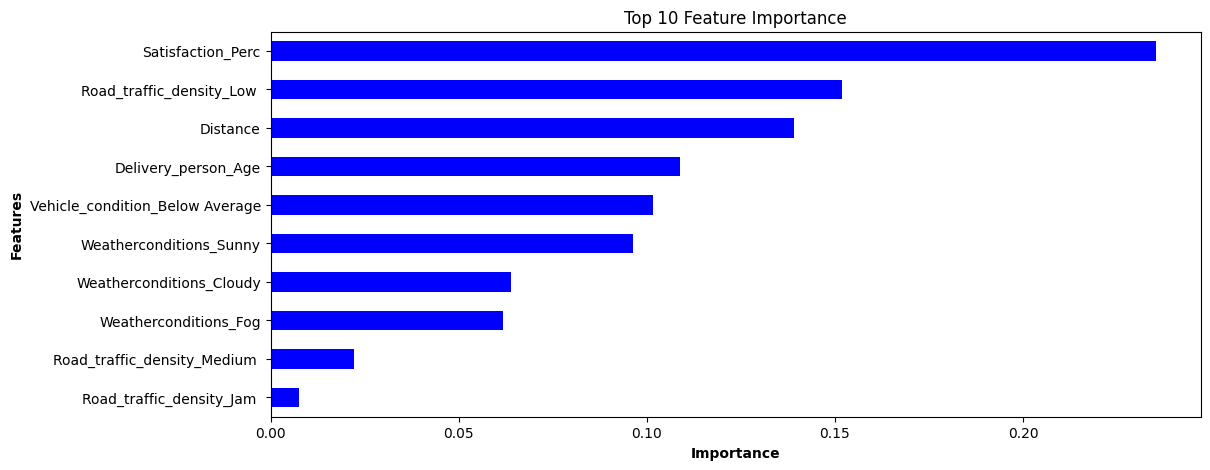

In [101]:
# helper function to get feature importance    
def plot_importance(model, X):

    importances = pd.Series(data=model.feature_importances_,
                            index= list(X.columns))
    
    importances_sorted = importances.sort_values()
    
    importances_sorted = importances_sorted[-10:]

    plt.figure(figsize = (12, 5))
    importances_sorted.plot(kind='barh', color='blue')
    plt.title('Top 10 Feature Importance')
    plt.xlabel("Importance", fontweight = 'bold')
    plt.ylabel("Features", fontweight = 'bold')
    plt.show()

plot_importance(rf_gs.best_estimator_.named_steps["random_forest"], X_train_encoded_rf)

### Gradient Boosting

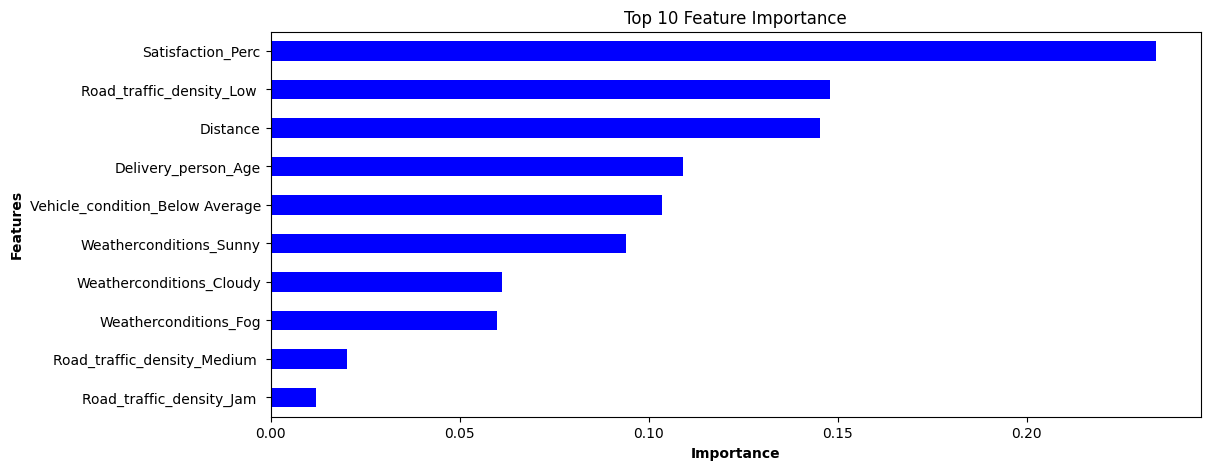

In [107]:
plot_importance(gb_gs.best_estimator_.named_steps['gb'], X_train_encoded_gb)

### Multi-Layer Perceptron

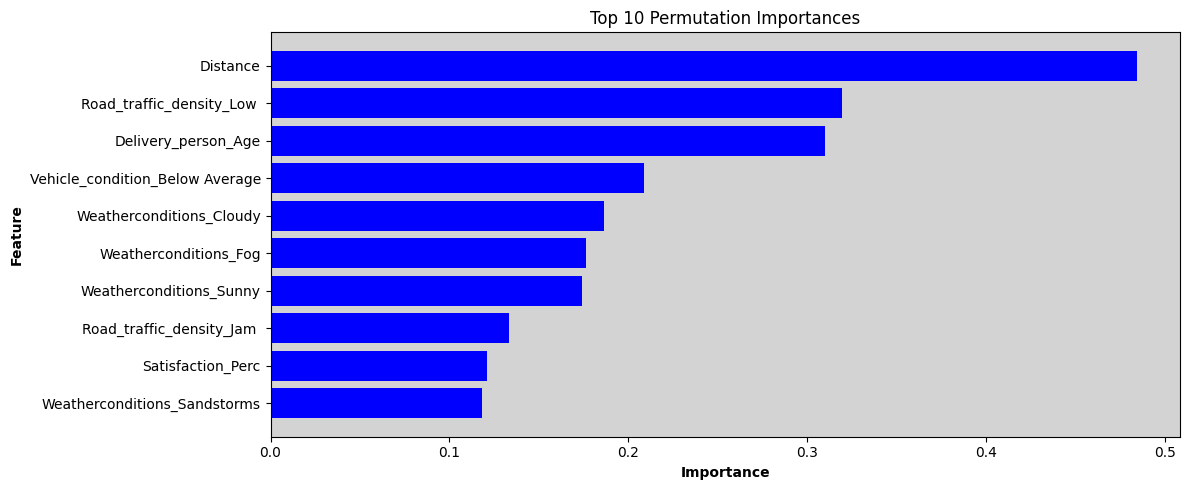

In [104]:
# plot feature importance
result = permutation_importance(nn_reg, X_test_encoded_nn, y_test, n_repeats = 10, random_state = 100)

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 5))
sorted_idx = result.importances_mean.argsort()[-10:]
ax.barh(X_test_encoded_nn.columns[sorted_idx], result.importances_mean[sorted_idx], color='blue')
ax.set_title("Top 10 Permutation Importances")
ax.set_facecolor('lightgrey')
ax.set_xlabel('Importance', fontweight = 'bold')
ax.set_ylabel('Feature', fontweight = 'bold')
ax.set_yticks(range(10))
ax.set_yticklabels(X_test_encoded_nn.columns[sorted_idx], fontsize=10)
fig.tight_layout()
plt.show()

From the feature importances plot, we can see that:
- Random Forest and Gradient Boosting placed the same importance on Satisfaction Percentage, Low traffic road density and distance. All 3 are very relevant factors that can affect delivery duration
- For the Neural Network, the most important feature was distance and it is very clear that it can and will affect delivery duration